# Forecasting
In this notebook we shall use the USA confirmed cases data set to train our forecasting model. In order to do so, we shall use the auto-arima function to determine the best model. Ultimately we shall implement the best model order to train a SARIMA model, which is extended ARIMA with seasonality support. 

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 16.1MB/s 
     |████████████████████████████████| 9.5MB 27.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Uploading data

In [2]:
from google.colab import files

uploaded = files.upload()#creating file input stream

for fn in uploaded.keys():#getting the input bytes
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#get name and length of file

Saving TS_Conf_dtt.csv to TS_Conf_dtt.csv
User uploaded file "TS_Conf_dtt.csv" with length 5556871 bytes


# Importing packages

In [3]:
import numpy as np
import pmdarima as pm
from pmdarima import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')
import statsmodels.api as sm
from pandas import DataFrame

# Reading data

In [4]:
conf_cases=pd.read_csv('TS_Conf_dtt.csv')
conf_cases

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1-22-2020,1-23-2020,1-24-2020,1-25-2020,1-26-2020,1-27-2020,1-28-2020,1-29-2020,1-30-2020,1-31-2020,02-01-2020,02-02-2020,02-03-2020,02-04-2020,02-05-2020,02-06-2020,02-07-2020,02-08-2020,02-09-2020,02-10-2020,02-11-2020,02-12-2020,2-13-2020,2-14-2020,2-15-2020,2-16-2020,2-17-2020,2-18-2020,2-19-2020,...,2-15-2021,2-16-2021,2-17-2021,2-18-2021,2-19-2021,2-20-2021,2-21-2021,2-22-2021,2-23-2021,2-24-2021,2-25-2021,2-26-2021,2-27-2021,2-28-2021,03-01-2021,03-02-2021,03-03-2021,03-04-2021,03-05-2021,03-06-2021,03-07-2021,03-08-2021,03-09-2021,03-10-2021,03-11-2021,03-12-2021,3-13-2021,3-14-2021,3-15-2021,3-16-2021,3-17-2021,3-18-2021,3-19-2021,3-20-2021,3-21-2021,3-22-2021,3-23-2021,3-24-2021,3-25-2021,3-26-2021
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6024,6038,6050,6071,6079,6092,6117,6121,6143,6172,6203,6228,6248,6264,6270,6303,6313,6324,6333,6344,6347,6364,6371,6400,6409,6409,6416,6426,6471,6474,6483,6495,6498,6510,6513,6517,6525,6533,6540,6543
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,19136,19176,19267,19324,19361,19392,19433,19461,19554,19635,19670,19698,19714,19732,19758,19790,19856,19873,19890,19915,19935,19942,19962,20012,20044,20072,20091,20103,20210,20227,20263,20287,20317,20329,20347,20361,20354,20395,20417,20423
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2044,2055,2053,2057,2061,2067,2070,2074,2084,2095,2099,2106,2113,2115,2116,2124,2129,2136,2139,2138,2139,2143,2147,2161,2171,2175,2181,2184,2195,2198,2199,2202,2206,2212,2212,2213,2213,2216,2218,2221
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2397,2400,2399,2405,2411,2414,2416,2417,2432,2437,2442,2445,2449,2450,2450,2454,2459,2461,2457,2460,2465,2464,2466,2469,2474,2475,2479,2481,2499,2508,2512,2519,2521,2528,2529,2529,2530,2535,2534,2535
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5973,5987,5997,6008,6021,6040,6042,6043,6058,6072,6086,6084,6095,6097,6102,6106,6229,6236,6246,6252,6256,6256,6255,6260,6274,6282,6288,6291,6353,6361,6371,6376,6380,6382,6383,6387,6388,6402,6408,6415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3278,3297,3298,3307,3318,3318,3326,3331,3333,3336,3342,3348,3348,3351,3357,3359,3364,3368,3375,3375,3375,3397,3395,3404,3418,3427,3427,3427,3467,3470,3484,3495,3510,3510,3510,3530,3532,3547,3549,3562
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1994,2007,2016,2021,2024,2024,2027,2030,2036,2037,2048,2054,2054,2053,2055,2062,2066,2070,2070,2070,2070,2076,2083,2084,2087,2088,2088,2088,2091,2094,2101,2101,2103,2103,2103,2109,2111,2113,2115,2119
3337,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,

# Getting date columns

In [5]:
cols=conf_cases.keys()
conf=conf_cases.loc[:, cols[11]:cols[-1]]#dates cols

# Storing total cumilative cases, total new cases and dates to seperate lists

In [6]:
dates=conf.keys()#date keys
cases_tot=[]
cases_new=[]

for i in dates:

  conf_sum=conf[i].sum()# sum of column
  cases_tot.append(conf_sum)#total cases per day
  if(i=='1-22-2020'):
    cases_new.append(conf_sum)
  else:
   cases_new.append(conf[i].sum()-conf[prev].sum())
  prev=i

print("Cumilative cases: ")
print(cases_tot, "\n")
print("Date keys: ")
print(dates, "\n")
print("New cases: ")
print(cases_new, "\n")

Cumilative cases: 
[1, 1, 2, 2, 5, 5, 5, 6, 6, 8, 8, 8, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 17, 17, 25, 32, 55, 75, 108, 185, 238, 404, 520, 595, 783, 1151, 1591, 2224, 2989, 3233, 4691, 6533, 9194, 13689, 20063, 26072, 34898, 46136, 56755, 68837, 86693, 105383, 125013, 143912, 165987, 192301, 224544, 256779, 289066, 321482, 351359, 382740, 413507, 444699, 480640, 515055, 544185, 571440, 598370, 627151, 652591, 682626, 715656, 743588, 769684, 799512, 825429, 854288, 887858, 920185, 950581, 977082, 1000785, 1025362, 1051800, 1081020, 1115946, 1143296, 1167593, 1191678, 1216209, 1240768, 1268180, 1295019, 1320155, 1339022, 1358293, 1381241, 1401649, 1428467, 1453214, 1477373, 1495736, 1518126, 1539133, 1561830, 1587596, 1611252, 1632364, 1652431, 1671104, 1690754, 1709303, 1731625, 1756098, 1779731, 1798718, 1816153, 1837656, 1857501, 1879150, 1904550, 1925710, 1943626, 1961263, 1979647, 2000757, 2023890, 2048756, 2073964, 20929

# Plot cumilative cases

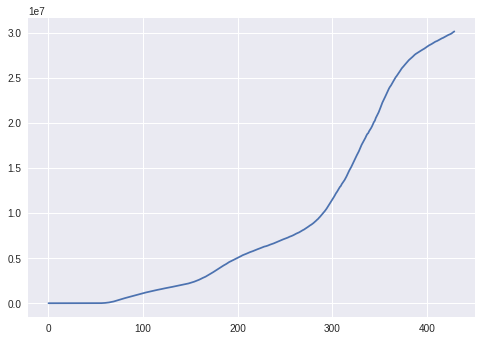

In [7]:
plt.plot(cases_tot)

# Reshaping as arrays

In [8]:
days=np.array([i for i in range (len (dates))]).reshape(-1,1)#day number
cases=np.array(cases_tot).reshape(-1,1)#cases per day
cases_n=np.array(cases_new).reshape(-1,1)#new cases


# Creating dataframes of cumilative cases, and splitting into train and test data

In [10]:
Cumilative_df= DataFrame(list(zip(dates,cases_tot)),columns=['Datetime','Count'])
train=Cumilative_df[0:400] 
test=Cumilative_df[400:]







# Converting dates to date-time format

In [11]:
Cumilative_df['Timestamp'] = pd.to_datetime(Cumilative_df.Datetime,format='%m-%d-%Y') 
Cumilative_df.index = Cumilative_df.Timestamp 
Cumilative_df = Cumilative_df.resample('D').mean()
train['Timestamp'] = pd.to_datetime(train.Datetime,format='%m-%d-%Y') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test['Timestamp'] = pd.to_datetime(test.Datetime,format='%m-%d-%Y') 
test.index = test.Timestamp 
test = test.resample('D').mean()



# Seasonal decomposition of cumilative cases

The data has a linear trend as well as a seasonality component.

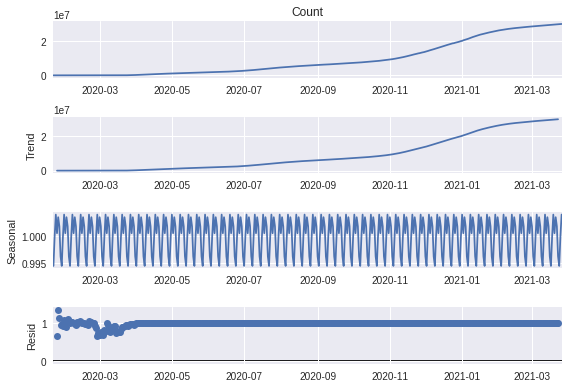

In [12]:
sm.tsa.seasonal_decompose(Cumilative_df.Count, model='multiplictive').plot()
plt.show()

# Using Auto_Arima function to determine the best model with minimum AIC

The best moel is of order: (5,2,3)X(0,0,1)[7]   

In [17]:
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=50,
                      seasonal=True, m=7, start_P=1, start_Q=2, start_D=1,max_P=5,max_D=5,max_Q=5)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,2)[7]             : AIC=8764.749, Time=2.09 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=8959.585, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=8812.159, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=8788.722, Time=0.15 sec
 ARIMA(2,2,2)(0,0,2)[7]             : AIC=8788.750, Time=0.75 sec
 ARIMA(2,2,2)(1,0,1)[7]             : AIC=8786.632, Time=0.50 sec
 ARIMA(2,2,2)(2,0,2)[7]             : AIC=8766.038, Time=2.51 sec
 ARIMA(2,2,2)(1,0,3)[7]             : AIC=8765.917, Time=3.35 sec
 ARIMA(2,2,2)(0,0,1)[7]             : AIC=8789.002, Time=0.35 sec
 ARIMA(2,2,2)(0,0,3)[7]             : AIC=8787.821, Time=1.36 sec
 ARIMA(2,2,2)(2,0,1)[7]             : AIC=inf, Time=2.98 sec
 ARIMA(2,2,2)(2,0,3)[7]             : AIC=8767.896, Time=5.74 sec
 ARIMA(1,2,2)(1,0,2)[7]             : AIC=8764.895, Time=1.49 sec
 ARIMA(2,2,1)(1,0,2)[7]             : AIC=8770.197, Time=1.27 sec
 ARIMA(3,2,2)(1,0,2)[7]             : 

# Training and fitting model to data based on the model order we got from auto_arima

We can see how our prediction is coinciding with validation data indicating a good performance of our model.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


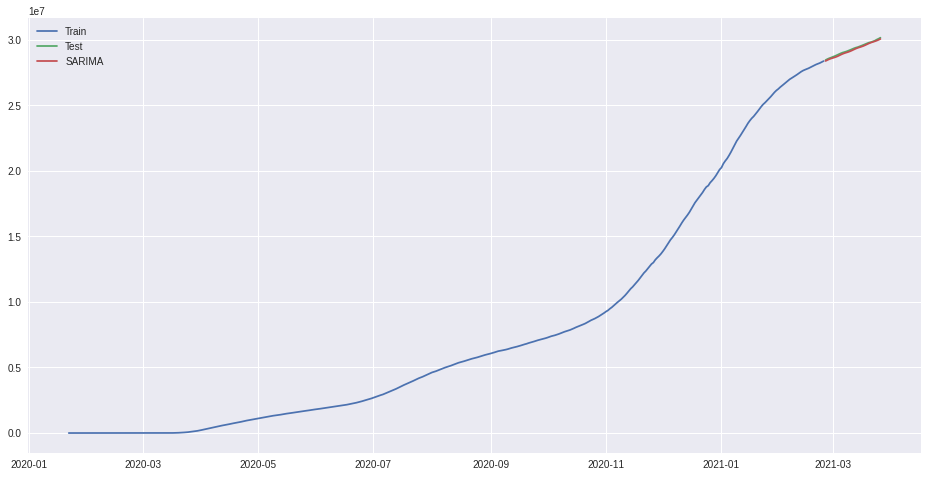

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Count   No. Observations:                  400
Model:             SARIMAX(5, 2, 3)x(0, 0, [1], 7)   Log Likelihood               -4362.842
Date:                             Fri, 21 May 2021   AIC                           8745.684
Time:                                     13:11:53   BIC                           8785.548
Sample:                                 01-22-2020   HQIC                          8761.474
                                      - 02-24-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3311      0.227     -1.458      0.145      -0.776       0.114
ar.L2          0.1678      0.170      0.989      0.323      -0.165       0.500
ar.L3         -0.7215      0.110     -6.541      0.000      -0.938      -0.505
ar.L4         -0.5341      0.078     -6.815      0.000      -0.688      -0.380
ar.L5         -0.2319      0.062     -3.748      0.000      -0.353      -0.111
ma.L1         -0.3414      0.229     -1.490      0.136      -0.791       0.108
ma.L2         -0.3106      0.299     -1.039      0.299      -0.897       0.276
ma.L3          0.9092      0.219      4.155      0.000       0.480       1.338
ma.S.L7        0.3629      0.030     12.284      0.000       0.305       0.421
sigma2      2.345e+08   1.16e-08   2.02e+16      0.000    2.35e+08    2.35e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7000.84
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             118.08   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.88e+31. Standard errors may be unstable.
"""

In [18]:
pred = test.copy()
fit = sm.tsa.statespace.SARIMAX(train.Count, order=(5, 2, 3),seasonal_order=(0,0,1,7)).fit()
pred['SARIMA'] = fit.predict(start="2-21-2021", end="3-26-2021", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(pred['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()
fit.summary()


# Calculating the Normalized root squared mean error 

A low value-- 0.048 shows our model is quiet accurate.

In [21]:
rmse=sm.tools.eval_measures.rmse(test.Count, pred['SARIMA'])
normalized_rmse=rmse/(30159998-28453812)
print("Normalized RMSE: ", normalized_rmse )

Normalized RMSE:  0.04804473568206044
